## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.7, 0.9]
redice_lr_patient = [5, 10, 15 ]

In [10]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 4s 77us/step - loss: 1.3673 - acc: 0.5257 - val_loss: 1.5391 - val_acc: 0.4595
Epoch 14/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3478 - acc: 0.5318 - val_loss: 1.5249 - val_acc: 0.4603
Epoch 15/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3302 - acc: 0.5385 - val_loss: 1.5170 - val_acc: 0.4690
Epoch 16/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3106 - acc: 0.5445 - val_loss: 1.5143 - val_acc: 0.4698
Epoch 17/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2931 - acc: 0.5511 - val_loss: 1.5132 - val_acc: 0.4760
Epoch 18/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2765 - acc: 0.5584 - val_loss: 1.4940 - val_acc: 0.4782
Epoch 19/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2600 - acc: 0.5616 - val_loss: 1.4936 - val_acc: 0.4832
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 5s 106us/step - loss: 2.3466 - acc: 0.2362 - val_loss: 2.1728 - val_acc: 0.2916
Epoch 2/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.8736 - acc: 0.3546 - val_loss: 1.9371 - val_acc: 0.3497
Epoch 3/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.7307 - acc: 0.3957 - val_loss: 1.7969 - val_acc: 0.3880
Epoch 4/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.6496 - acc: 0.4242 - val_loss: 1.7296 - val_acc: 0.4085
Epoch 5/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5940 - acc: 0.4427 - val_loss: 1.6777 - val_acc: 0.4222
Epoch 6/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.5497 - acc: 0.4580 - val_loss: 1.6446 - val_acc: 0.4332
Epoch 7/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.5127 - acc: 0.4706 - val_loss: 1.6266 - val_acc: 0.4404
Epoch 8/25
50000/50000 [===========================

50000/50000 [==============================] - 4s 79us/step - loss: 1.1694 - acc: 0.5980 - val_loss: 1.4656 - val_acc: 0.4840
Epoch 25/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.1557 - acc: 0.6045 - val_loss: 1.4618 - val_acc: 0.4899
Numbers of exp: 5, reduce_factor: 0.70, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_43 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3901 - acc: 0.5164 - val_loss: 1.5623 - val_acc: 0.4582
Epoch 13/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3699 - acc: 0.5252 - val_loss: 1.5488 - val_acc: 0.4645
Epoch 14/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3486 - acc: 0.5312 - val_loss: 1.5400 - val_acc: 0.4650
Epoch 15/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3294 - acc: 0.5395 - val_loss: 1.5323 - val_acc: 0.4668
Epoch 16/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.3116 - acc: 0.5462 - val_loss: 1.5269 - val_acc: 0.4700
Epoch 17/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2955 - acc: 0.5515 - val_loss: 1.5217 - val_acc: 0.4708
Epoch 18/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2786 - acc: 0.5591 - val_loss: 1.5131 - val_acc: 0.4736
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 114us/step - loss: 2.3469 - acc: 0.2369 - val_loss: 2.2366 - val_acc: 0.2885
Epoch 2/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.8742 - acc: 0.3535 - val_loss: 1.9447 - val_acc: 0.3428
Epoch 3/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.7375 - acc: 0.3949 - val_loss: 1.7883 - val_acc: 0.3823
Epoch 4/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.6567 - acc: 0.4209 - val_loss: 1.7313 - val_acc: 0.4005
Epoch 5/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.6007 - acc: 0.4410 - val_loss: 1.6892 - val_acc: 0.4106
Epoch 6/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5572 - acc: 0.4552 - val_loss: 1.6499 - val_acc: 0.4261
Epoch 7/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.5202 - acc: 0.4685 - val_loss: 1.6195 - val_ac

50000/50000 [==============================] - 5s 91us/step - loss: 0.4841 - acc: 0.8580 - val_loss: 1.5111 - val_acc: 0.5183
Epoch 23/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.4619 - acc: 0.8684 - val_loss: 1.5492 - val_acc: 0.5156
Epoch 24/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.4465 - acc: 0.8725 - val_loss: 1.5147 - val_acc: 0.5261
Epoch 25/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.4316 - acc: 0.8786 - val_loss: 1.5456 - val_acc: 0.5190
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batc

50000/50000 [==============================] - 5s 90us/step - loss: 1.1371 - acc: 0.6115 - val_loss: 1.4589 - val_acc: 0.4813
Epoch 10/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.1061 - acc: 0.6209 - val_loss: 1.4493 - val_acc: 0.4867
Epoch 11/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.0737 - acc: 0.6348 - val_loss: 1.4351 - val_acc: 0.4929
Epoch 12/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.0433 - acc: 0.6462 - val_loss: 1.4397 - val_acc: 0.4990
Epoch 13/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.0159 - acc: 0.6578 - val_loss: 1.4569 - val_acc: 0.4912
Epoch 14/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.9903 - acc: 0.6672 - val_loss: 1.4737 - val_acc: 0.4899
Epoch 15/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.9624 - acc: 0.6777 - val_loss: 1.4331 - val_acc: 0.4960
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.9202 - acc: 0.3490 - val_loss: 1.8760 - val_acc: 0.3529
Epoch 2/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.5778 - acc: 0.4484 - val_loss: 1.6286 - val_acc: 0.4278
Epoch 3/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.4830 - acc: 0.4816 - val_loss: 1.5989 - val_acc: 0.4381
Epoch 4/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.4195 - acc: 0.5071 - val_loss: 1.5634 - val_acc: 0.4491
Epoch 5/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.3712 - acc: 0.5233 - val_loss: 1.5201 - val_acc: 0.4622
Epoch 6/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.3310 - acc: 0.5387 - val_loss: 1.5233 - val_acc: 0.4684
Epoch 7/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.2935 - acc: 0.5524 - val_loss: 1.5019 - val_ac

50000/50000 [==============================] - 5s 94us/step - loss: 0.9573 - acc: 0.6868 - val_loss: 1.4596 - val_acc: 0.4949
Epoch 25/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.9444 - acc: 0.6907 - val_loss: 1.4421 - val_acc: 0.4983
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_73 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 11/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.2160 - acc: 0.5852 - val_loss: 1.4972 - val_acc: 0.4817
Epoch 12/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.1927 - acc: 0.5942 - val_loss: 1.4896 - val_acc: 0.4817
Epoch 13/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.1698 - acc: 0.6045 - val_loss: 1.4679 - val_acc: 0.4879
Epoch 14/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.1520 - acc: 0.6110 - val_loss: 1.4692 - val_acc: 0.4877
Epoch 15/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.1328 - acc: 0.6175 - val_loss: 1.4546 - val_acc: 0.4924
Epoch 16/25
50000/50000 [==============================] - 5s 96us/step - loss: 1.1135 - acc: 0.6259 - val_loss: 1.4514 - val_acc: 0.4963
Epoch 17/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.0972 - acc: 0.6321 - val_loss: 1.4642 - val_acc: 0.4890
Epoch 18/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.8049 - acc: 0.3730 - val_loss: 2.1402 - val_acc: 0.3025
Epoch 2/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.5333 - acc: 0.4574 - val_loss: 2.8545 - val_acc: 0.2382
Epoch 3/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.4315 - acc: 0.4947 - val_loss: 2.3685 - val_acc: 0.2653
Epoch 4/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.3559 - acc: 0.5204 - val_loss: 2.2623 - val_acc: 0.3071
Epoch 5/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.2954 - acc: 0.5418 - val_loss: 2.2972 - val_acc: 0.2539
Epoch 6/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.2398 - acc: 0.5626 - val_loss: 1.7773 - val_acc: 0.3740
Epoch 7/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.1967 - acc: 0.5773 - val_loss: 2.1083 - val_ac

50000/50000 [==============================] - 5s 91us/step - loss: 0.6908 - acc: 0.7732 - val_loss: 2.0029 - val_acc: 0.4028
Epoch 24/25
50000/50000 [==============================] - 5s 91us/step - loss: 0.6731 - acc: 0.7778 - val_loss: 2.0106 - val_acc: 0.4111
Epoch 25/25
50000/50000 [==============================] - 5s 90us/step - loss: 0.6473 - acc: 0.7855 - val_loss: 1.9342 - val_acc: 0.4082
Numbers of exp: 20, reduce_factor: 0.50, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_88 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_lay

Epoch 11/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.0421 - acc: 0.6407 - val_loss: 2.1484 - val_acc: 0.3457
Epoch 12/25
50000/50000 [==============================] - 5s 93us/step - loss: 1.0065 - acc: 0.6527 - val_loss: 1.7774 - val_acc: 0.4064

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00017500000831205398.
Epoch 13/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.9315 - acc: 0.6852 - val_loss: 1.5448 - val_acc: 0.4658
Epoch 14/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.8991 - acc: 0.6974 - val_loss: 1.5805 - val_acc: 0.4627
Epoch 15/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.8682 - acc: 0.7077 - val_loss: 1.5517 - val_acc: 0.4641
Epoch 16/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.8395 - acc: 0.7206 - val_loss: 1.4919 - val_acc: 0.4896
Epoch 17/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.8145 - a

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.9707 - acc: 0.3308 - val_loss: 2.0160 - val_acc: 0.3380ss: 1.9861 - acc: 0.3 - ETA: 0s - loss: 1.9736 - acc: 0.330
Epoch 2/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.6466 - acc: 0.4246 - val_loss: 1.9123 - val_acc: 0.3695
Epoch 3/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.5308 - acc: 0.4640 - val_loss: 1.7347 - val_acc: 0.4022
Epoch 4/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.4543 - acc: 0.4921 - val_loss: 1.7515 - val_acc: 0.3967
Epoch 5/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.3939 - acc: 0.5137 - val_loss: 1.6966 - val_acc: 0.4148
Epoch 6/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.3444 - acc: 0.5317 - val_loss: 1.6074 - val_acc: 0.4390
Epoch 7/25
50000/50000 [==============================] - 5s 95us/st

50000/50000 [==============================] - 5s 94us/step - loss: 0.8138 - acc: 0.7355 - val_loss: 1.5784 - val_acc: 0.4712
Epoch 24/25
50000/50000 [==============================] - 5s 96us/step - loss: 0.7940 - acc: 0.7441 - val_loss: 1.5312 - val_acc: 0.4852

Epoch 00024: ReduceLROnPlateau reducing learning rate to 6.945749846636318e-05.
Epoch 25/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.7644 - acc: 0.7570 - val_loss: 1.5193 - val_acc: 0.4836
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_103 (Bat (None, 512)               2048  

50000/50000 [==============================] - 5s 100us/step - loss: 1.2627 - acc: 0.5654 - val_loss: 1.5543 - val_acc: 0.4535
Epoch 10/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.2277 - acc: 0.5791 - val_loss: 1.5569 - val_acc: 0.4485
Epoch 11/25
50000/50000 [==============================] - 5s 99us/step - loss: 1.1970 - acc: 0.5891 - val_loss: 1.4997 - val_acc: 0.4717
Epoch 12/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1656 - acc: 0.6029 - val_loss: 1.5463 - val_acc: 0.4649
Epoch 13/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.1371 - acc: 0.6143 - val_loss: 1.5262 - val_acc: 0.4695
Epoch 14/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.1096 - acc: 0.6239 - val_loss: 1.4950 - val_acc: 0.4768
Epoch 15/25
50000/50000 [==============================] - 5s 100us/step - loss: 1.0832 - acc: 0.6357 - val_loss: 1.5440 - val_acc: 0.4711
Epoch 16/25
50000/50000 [===============

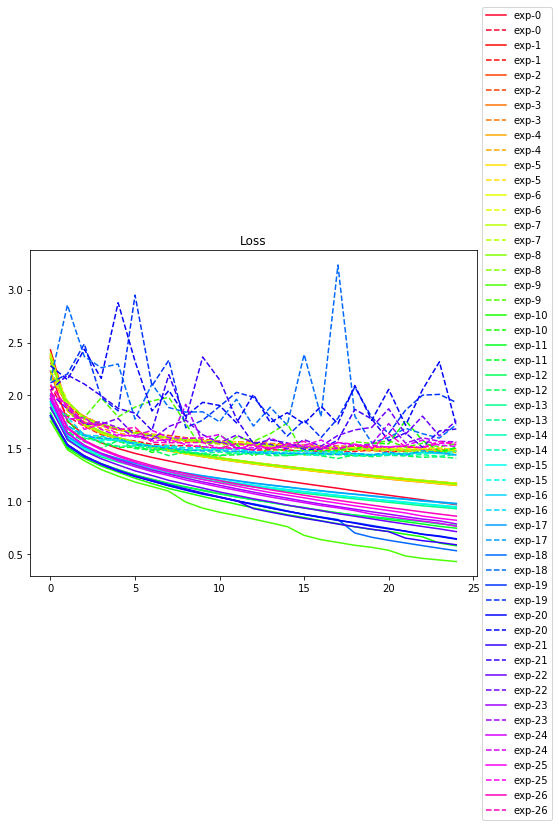

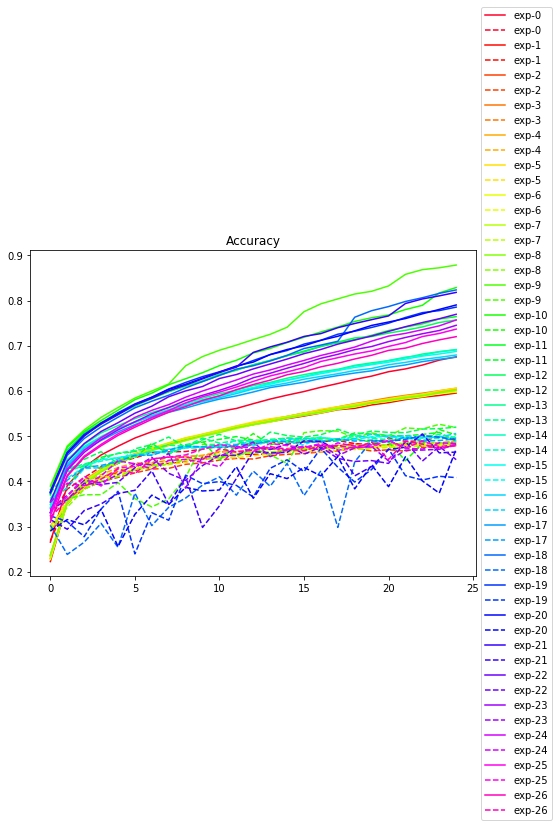

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()